<a href="https://colab.research.google.com/github/gigihArmy/chatbot_lstm_DL/blob/main/lstm_chatbot_tanmalaka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt
import pickle

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model, load_model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D

## Load Dataset

In [2]:
# Ambil Dataset dari GItHub
!wget https://raw.githubusercontent.com/gigihArmy/chatbot_lstm_DL/refs/heads/main/dataset_dl.json -O data.json

# Membaca file JSON
import json

with open('data.json') as f:
    data = json.load(f)
    print(data)

--2025-01-29 07:46:11--  https://raw.githubusercontent.com/gigihArmy/chatbot_lstm_DL/refs/heads/main/dataset_dl.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161883 (158K) [text/plain]
Saving to: ‘data.json’

data.json           100%[===================>] 158.09K  --.-KB/s    in 0.04s   

2025-01-29 07:46:11 (3.44 MB/s) - ‘data.json’ saved [161883/161883]

{'intens': [{'tag': 'salam', 'patterns': ['Halo', 'Hai', 'Selamat pagi', 'Selamat siang', 'Apa kabar?', 'Halo cui', 'Halo rek', 'Halo bro apa kabar', 'Selamat sore', 'Selamat malam', 'Apa kabar?', 'Gimana kabarmu?', 'Apa yang bisa saya bantu?', 'Apa yang sedang kamu lakukan?', 'Selamat datang', 'Apa yang sedang terjadi?', 'Hallo', 'Hey', 'Hi, apa kabar?', 'Apa kabar hari ini?', 'Kamu baik-baik saja?

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
#Mendapatkan semua data dalam list
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data['intens']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))

      if intent['tag'] not in classes:
        classes.append(intent['tag'])

In [5]:
with open('responses.json', 'w') as f:
    json.dump(responses, f, indent=4)

In [6]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, tags, test_size=0.2, random_state=20)
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  1514 non-null   object
 1   tags      1514 non-null   object
dtypes: object(2)
memory usage: 23.8+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  379 non-null    object
 1   tags      379 non-null    object
dtypes: object(2)
memory usage: 6.1+ KB


In [9]:
train_data.describe()

,patterns,tags
count,1514,1514
unique,1503,44
top,Hubungan dialektika sama materialisme apa ya?,madilog_penerapan
freq,2,82


In [10]:
test_data.describe()

,patterns,tags
count,379,379
unique,378,44
top,Apa pandangan Tan Malaka tentang nasionalisme?,madilog_penerapan
freq,2,21


In [11]:
train_data.head()

,patterns,tags
0,Kenapa Tan Malaka suka dibahas di dunia akademik?,tan_malaka_relevansi_saat_ini
1,Bagaimana Tan Malaka mengkritik kapitalisme?,tan_malaka_kritik_terhadap_kapitalisme
2,"Kalau liat sesuatu dari sudut pandang nyata, i...",materialisme_contoh
3,Tan Malaka beneran nggak ada pas kemerdekaan?,pencarian_tan_malaka
4,Komunis banget ya Tan Malaka?,tan_malaka_komunis


In [12]:
test_data.head()

,patterns,tags
0,Tan Malaka itu bagaimana dalam memperjuangkan ...,tan_malaka_perjuangan
1,Bagaimana cerita akhir hidup Tan Malaka?,tan_malaka_kematian
2,Buku Madilog Tan Malaka tuh masih kepake nggak...,tan_malaka_relevansi_saat_ini
3,Apa peran Tan Malaka dalam pembentukan negara ...,tan_malaka_perjuangan
4,Ada tips nggak biar gue makin logis?,logika_contoh


## Text Preprocessing

In [13]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [14]:
#inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  tokens = nltk.word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  lemmatized_text = ' '.join(lemmatized_tokens)
  return lemmatized_text

train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [15]:
#Tokenisasi Data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

X_train = tokenizer.texts_to_sequences(train_data['patterns'])
X_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [16]:
#Apply Padding
max_sequence_length = max(len(seq) for seq in X_train + X_test)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [17]:
#Kombinasi tag dari train_data dan test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [18]:
# Simpan nilai max_sequence_length
with open("max_sequence_length.json", "w") as f:
    json.dump({"max_sequence_length": max_sequence_length}, f)

# Simpan LabelEncoder ke file pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Simpan word index
with open("tokenizer_word_index.json", "w") as f:
    json.dump(tokenizer.word_index, f)

In [ ]:
train_dataset = (X_train, y_train)
test_dataset = (X_test, y_test)

## Download Embedding Bahasa Indonesia

In [ ]:
import requests

# URL FastText embeddings bahasa Indonesia
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"

# Nama file untuk menyimpan hasil unduhan
output_file = "cc.id.300.vec.gz"

print("Downloading FastText embeddings for Indonesian...")
response = requests.get(url, stream=True)

with open(output_file, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"FastText embeddings downloaded and saved as {output_file}")


FastText embeddings downloaded and saved as cc.id.300.vec.gz


In [ ]:
import gzip
import shutil

# File yang diunduh
compressed_file = "cc.id.300.vec.gz"
extracted_file = "cc.id.300.vec"

print("Extracting FastText embeddings...")
with gzip.open(compressed_file, "rb") as f_in:
    with open(extracted_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"File extracted and saved as {extracted_file}")


Extracting FastText embeddings...
File extracted and saved as cc.id.300.vec


In [ ]:
# Melihat beberapa baris pertama dari file
with open("cc.id.300.vec", "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:  # Cetak 5 baris pertama
            break


2000000 300
, 0.0183 -0.0404 -0.0395 0.1229 0.0618 0.0565 -0.0779 -0.0407 -0.0291 0.0576 0.0657 -0.0430 -0.0021 -0.0458 -0.0132 0.0089 -0.0113 0.0401 0.0180 -0.0375 0.0785 0.0343 -0.0198 -0.0528 -0.0672 0.0253 0.0055 -0.0146 -0.3152 -0.0715 0.1358 0.0030 -0.0072 -0.0426 -0.0688 0.0144 -0.0659 0.0574 0.0455 0.0627 0.0093 -0.0405 -0.0428 -0.0014 -0.0373 -0.0410 -0.1958 -0.0225 -0.0270 -0.0086 -0.0368 -0.0131 -0.0343 0.3139 -0.0489 0.0225 -0.1792 -0.0570 0.1698 -0.0275 0.0008 0.0186 -0.0361 0.0036 0.0356 -0.0258 0.0205 -0.0130 0.0609 -0.0564 0.0818 -0.0085 0.0117 -0.0182 -0.0567 0.0169 -0.0649 0.0420 -0.0049 -0.0469 -0.0438 0.0168 0.0049 -0.0019 -0.0086 -0.0399 0.0553 0.1233 -0.0834 0.0228 0.0380 0.0788 0.1494 0.0223 -0.0073 -1.0348 -0.0141 -0.0839 0.0066 -0.0121 -0.0218 0.0307 0.0266 0.0165 -0.0789 -0.0476 -0.0421 0.0650 0.0017 -0.0051 0.0138 0.1108 0.0192 0.0312 0.0101 0.0154 -0.0734 0.0402 0.0107 -0.0304 0.0464 0.0296 0.0664 -0.0754 0.0293 -0.0405 -0.0370 -0.0597 -0.0431 -0.0367 -0.014

In [ ]:
# Path ke file hasil ekstraksi
fasttext_file_path = "cc.id.300.vec"

# Dimensi embedding FastText
embedding_dim = 300

# Membaca file FastText embeddings
embeddings_index = {}
with open(fasttext_file_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from FastText.")

Loaded 2000000 word vectors from FastText.


In [ ]:
# Membuat matriks embedding untuk kata-kata dalam tokenizer
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Gunakan vector FastText jika tersedia


## Arsitektur Model

In [ ]:
#Model
regularization = regularizers.l2(0.01)

#Dropout
dropout_rate = 0.5

#Input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer dengan pretrained FastText
embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Gunakan pretrained FastText weights
    input_length=max_sequence_length,
    trainable=False  # Set False agar tidak melatih ulang embedding
)(input_layer)

#LSTM layer
lstm_units = 16
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

#Flatten layer
x = Flatten()(x)

#Dense layer
dense_units = 50
x = Dense(dense_units, activation='relu')(x)
x = Dropout(dropout_rate)(x)

#Output layer
num_classes = len(classes)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 13, 300)             │         311,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 13, 32)              │          40,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          20,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 44)                  │           2,244 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,770 (1.43 MB)

 Trainable params: 63,670 (248.71 KB)

 Non-trainable params: 311,100 (1.19 MB)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.7):
      print("\nValidasi Akurasi telah mencapai 70%, stop training")

      self.model.stop_training = True

In [ ]:
cb = myCallback()
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Train model
history = model.fit(train_dataset[0], train_dataset[1], batch_size=32, epochs=250, callbacks=[cb], validation_data=test_dataset)

Epoch 1/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.0153 - loss: 3.7854 - val_accuracy: 0.0264 - val_loss: 3.7818
Epoch 2/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0280 - loss: 3.7804 - val_accuracy: 0.0290 - val_loss: 3.7770
Epoch 3/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0338 - loss: 3.7734 - val_accuracy: 0.0554 - val_loss: 3.7708
Epoch 4/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0405 - loss: 3.7665 - val_accuracy: 0.0818 - val_loss: 3.7629
Epoch 5/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0680 - loss: 3.7594 - val_accuracy: 0.0871 - val_loss: 3.7519
Epoch 6/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0638 - loss: 3.7449 - val_accuracy: 0.0950 - val_loss: 3.7364
Epoch 7/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0488 - loss: 3.7316 - val_accuracy: 0.0844 - val_loss: 3.7146
Epoch 8/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0710 - loss: 3.7019 - val_accuracy: 0.

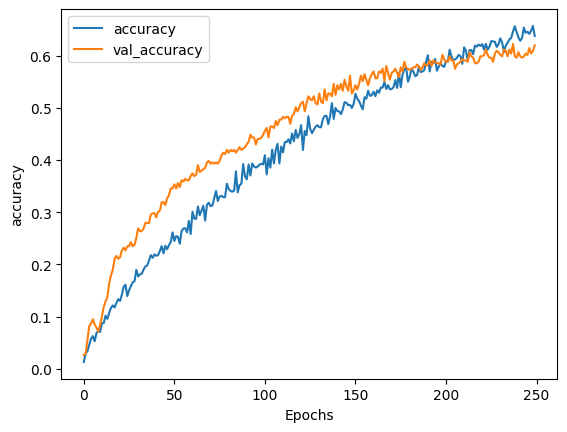

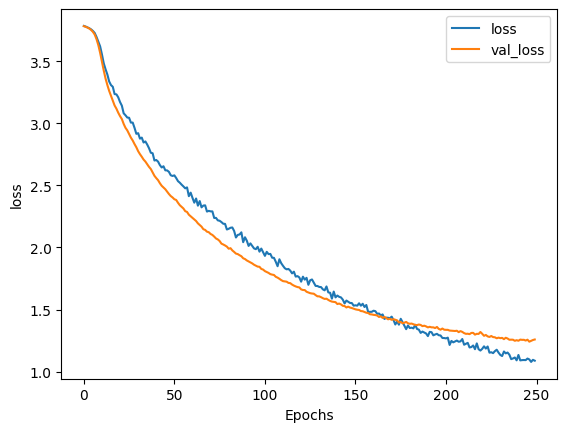

In [ ]:
#Vis akurasi dan loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Uji Coba Chatbot dan Simpan Model

In [ ]:
#chat input
while True:
  texts = []
  prediction_input = input("Anda: ")

  #hapus punk dan lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts.append(prediction_input)

  #tokenisasi dan padding
  prediction_input = tokenizer.texts_to_sequences(texts)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], maxlen=max_sequence_length)

  output = model.predict(prediction_input)
  output = output.argmax()

  # Menghitung confidence level (probabilitas tertinggi dari prediksi)
  confidence = output.max()  # Ambil probabilitas tertinggi

  # Tentukan ambang batas confidence
  threshold = 0.6  # Anda bisa menyesuaikan nilai threshold ini
  if confidence < threshold:
      response_tag = "unknown"
      print("ChatBot: Maaf, saya tidak tahu jawabannya.")
  else:
      # Jika confidence lebih tinggi dari threshold, gunakan tag yang diprediksi
      response_tag = le.inverse_transform([output])[0]
      print("ChatBot: ", random.choice(responses[response_tag]))

  #response_tag = le.inverse_transform([output])[0]
  #print("ChatBot: ", random.choice(responses[response_tag]))
  if response_tag == "perpisahan":
    break

Anda: live yt ace anthem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
ChatBot:  Malakan adalah sebutan bagi yang mengunjungi kesini untuk menanyakan tentang Tokoh Pahlawan Tan Malaka. :)
Anda: halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
ChatBot:  Selamat datang Malakan! Aku akan membantu menjawab pertanyaan seputar Tan Malaka disini. Kamu mau nanya apa?
Anda: siapa malakan?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ChatBot:  Malakan untuk menyapa kamu yang berkunjung kesini untuk membahas seputar tokoh pahalawan Indonesia yaitu Tan Malaka.
Anda: siapa tan malaka?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ChatBot:  Tan Malaka meninggal dunia pada tahun 1949, diduga ditembak oleh tentara Republik Indonesia di Jawa Timur.
Anda: siapakah tan malaka?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
ChatBot:  Tan Malaka meninggal pada tahun 1949 karena dieksekusi oleh pasukan TNI akibat perbedaan ideologi dan konflik politik. Meskipun demikian, ia dianugerahi gelar Pahlawan Nasional Indonesia pada tahun 1963.
Anda: S

In [ ]:
model.save("chatbot_lstm_model.keras")

## Load Model Chatbot Keras

Jika sudah ada model dan ingin langsung uji coba chatbot, jalankan tahap import library hingga text preprocessing terlebih dahulu

In [29]:
# Load label encoder (misalnya dengan pickle)
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load data respons
with open('responses.json', 'r') as f:
    responses = json.load(f)

# Load Max_sequence_length
with open('max_sequence_length.json', 'r') as f:
    max_sequence_length = json.load(f)['max_sequence_length']

# Load word index
with open("tokenizer_word_index.json", "r") as f:
    word_index = json.load(f)

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.word_index = word_index

# Load model
model = load_model("chatbot_lstm_model.keras")

while True:
    texts = []
    prediction_input = input("Anda: ")

    # Hapus tanda baca dan konversi ke lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts.append(prediction_input)

    # Tokenisasi dan padding
    prediction_input = tokenizer.texts_to_sequences(texts)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], maxlen=max_sequence_length)

    # Prediksi kelas tag
    output = model.predict(prediction_input)
    output = output.argmax()

    # Menghitung confidence level (probabilitas tertinggi dari prediksi)
    confidence = output.max()  # Ambil probabilitas tertinggi

    # Tentukan ambang batas confidence
    threshold = 0.6  # Anda bisa menyesuaikan nilai threshold ini
    if confidence < threshold:
        response_tag = "unknown"
        print("ChatBot: Maaf, saya tidak tahu jawabannya.")
    else:
        # Jika confidence lebih tinggi dari threshold, gunakan tag yang diprediksi
        response_tag = le.inverse_transform([output])[0]
        print("ChatBot: ", random.choice(responses[response_tag]))

    if response_tag == "perpisahan":
        break

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Anda: halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
ChatBot:  Hai kawan! Mau kepoin siapa Tan Malaka?. Langsung aja tanya ya
Anda: nama kamu siapa?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
ChatBot:  Nama saya adalah Chatbot! Saya di sini untuk membantu menjawab pertanyaan mengenai Tan malaka.
Anda: siapa tan malaka??
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
ChatBot:  Tan Malaka adalah seorang pemimpin revolusioner dan intelektual asal Indonesia yang lahir pada 2 Juni 1897 di Nagari Pandan Gadang, Sumatera Barat.
Anda: apa perjuangan tan malaka bagi indonesia?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ChatBot:  Pemikiran Tan Malaka membantu membentuk dasar-dasar perjuangan kemerdekaan Indonesia.
Anda: apa pemikiran yang terkenal dari tan malaka?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ChatBot:  Beliau dikenal sebagai pendiri Partai Murba dan aktif memperjuangkan kemerdekaan melalui organisasi politik lainnya.
Anda: apa peran tan malaka dalam politik indonesia?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Ch

In [21]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [32]:
import gradio as gr

model = load_model("chatbot_lstm_model.keras")

def chatbot_response(text):
    # Jika input kosong
    if not text.strip():
        return "Silahkan ajukan pertanyaan"

    # Tokenisasi dan padding input
    texts = [text]
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_sequence_length)

    # Prediksi kelas dengan model
    output = model.predict(padded)
    output = output.argmax(axis=1)[0]

    # Dapatkan respons berdasarkan kelas yang diprediksi
    response_tag = le.inverse_transform([output])[0]
    return np.random.choice(responses[response_tag])

# Interface Gradio
iface = gr.Interface(
    fn=chatbot_response,
    inputs="text",
    outputs="text",
    live=True,
    title="Chatbot Tan Malaka",
    description="Selamat datang di chatbot Tan Malaka! Di sini Anda bisa bertanya tentang pemikiran, perjuangan, dan sejarah Tan Malaka. Silakan ajukan pertanyaan dan chatbot ini akan memberikan jawaban berdasarkan data dan model yang telah dilatih."
)

# Jalankan antarmuka
iface.launch()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7bb052ed6b31f132e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
